# Comparison of HulC and Wald intervals:
## Simple Linear Regression

In [1]:
### HulC.R contains all the functions related to the HulC procedure.
source("HulC.R")

### loading necessary packages for computation and plotting.
library("sandwich")
library(ggplot2)
library("cowplot")
library("gridExtra")
library("repr")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'cowplot' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"

In the following, we will compare the HulC and Wald confidence intervals for the slope in a potentially misspecified linear model. We have observations $(X_i, Y_i), 1\le i\le n$ from the model
\begin{equation*}
Y_i = 1 + 2X_i + \gamma X_i^{1.7} + \exp(\gamma X_i)\xi_i,
\label{eq:DGP}\tag{DGP}
\end{equation*}
where $\xi_i$ is a standard Gaussian random variable independent of $X_i$. The estimator we use is the classical OLS linear regression estimator:
$$(\widehat{\alpha}, \widehat{\beta}) := \underset{(\alpha,\beta)}{\text{argmin}} \sum_{i=1}^n (Y_i - \alpha - \beta X_i)^2.$$
The target of $(\widehat{\alpha}, \widehat{\beta})$ is given by
$$(\alpha_{\gamma}, \beta_{\gamma}) := \underset{(\alpha,\beta)}{\text{argmin}} \mathbb{E}_{\gamma}[(Y - \alpha - \beta X)^2],$$
where $\mathbb{E}_{\gamma}$ is the expectation with respect to $(X, Y)$, when they are also generated from the model \eqref{eq:DGP}. Our target of inference is the parameter $\beta_{\gamma}$ for $\gamma$ in an equi-spaced grid of size 5 between $0$ and $1$. Note that for $\gamma = 0$, the data generating model \eqref{eq:DGP} is a well-specified linear model. 

It is important to note that $(\alpha_{\gamma}, \beta_{\gamma}) \neq (1, 2)$ for any $\gamma > 0$. We find the values of $\beta_{\gamma}$ for $\gamma$ in the grid by generating $10^8$ samples from the model \eqref{eq:DGP} and performing least squares regression. The following code performs this operation.  

In [2]:
## The following code is precomputed because it is computationally expensive.
gamma_seq <- seq(0, 1, length = 5)
## Finding the projection parameter values using 
## Monte Carlo simulation
# proj_beta <- rep(0, length(gamma_seq))
# names(proj_beta) <- paste0("gamma_", gamma_seq)
# for(idx in 1:length(gamma_seq)){
#   beta0 <- 1
#   beta1 <- 2
#   nsamp <- 1e08
#   gamma <- gamma_seq[idx]
#   x <- runif(nsamp, 0, 10)
#   y <- beta0 + beta1*x + gamma*x^{1.7} + exp(gamma*x)*rnorm(nsamp)
#   data <- cbind(1, x, y)
#   proj_beta[idx] <- unname(lm.fit(data[,c(1,2)], data[,3])$coefficients[2])
# }
proj_beta <- c(2.000038, 3.279129, 4.556705, 5.823864, 6.809289)
names(proj_beta) <- paste0("gamma_",gamma_seq)

Now that we found the projection parameter values (i.e., $\beta_{\gamma}$ for $\gamma$ in the grid), our aim is to construct confidence intervals to contain $\beta_{\gamma}$. Note that $\widehat{\beta}$ is consistent for $\beta_{\gamma}$ whenever the data is generated from \eqref{eq:DGP}. The classical Wald interval with sandwich covariance matrix is an asymptotically valid confidence interval for $\beta_{\gamma}$. Because the limiting distribution is Gaussian, the asymptotic median bias of $\widehat{\beta}$ is zero and hence HulC can be applied $\Delta = 0$; this is Algorithm 1 in the paper. The following function (`foo`) generates data from \eqref{eq:DGP} and computes the HulC and Wald confidence intervals at the confidence of $95\%$.  

In [3]:
foo <- function(nsamp, gamma, name, alpha = 0.05){
    beta0 <- 1
    beta1 <- 2
    x <- runif(nsamp, 0, 10)
    y <- beta0 + beta1*x + gamma*x^{1.7} + exp(gamma*x)*rnorm(nsamp)
    data <- cbind(x, y)
    if(name == "HulC"){
        estimate <- function(dat_tmp){
            fit <- lm(dat_tmp[,2] ~ dat_tmp[,1])
            return(unname(fit$coeff)[2])
        }
        tmp <- as.vector(HulC(data, estimate, alpha = alpha, Delta = 0, dim = 1)$CI)
    }
    if(name == "Wald"){
        mod <- lm(data[,2] ~ data[,1])
        est <- unname(mod$coeff[2])
        sd_est <- sqrt(vcovHC(mod, type = "HC")[2,2])
        tmp <- est + c(-1, 1)*qnorm(1-alpha/2)*sd_est
    }
    return(tmp)
}

## HulC confidence interval
print("HulC confidence interval:")
foo(100, 0, "HulC", alpha = 0.05)

## Wald confidence interval
print("Wald confidence interval:")
foo(100, 0, "Wald", alpha = 0.05)

[1] "HulC confidence interval:"


[1] 1.872736 2.142502

[1] "Wald confidence interval:"


[1] 1.919061 2.060327

## Simulation
The following code chunk computes the HulC and Wald intervals for different sample sizes and different $\gamma$ values. For reproducibility, the seed is set at 2021. For each sample size and $\gamma$, we perform 1000 replications to compute the width and coverage.

In [4]:
nsamp_seq <- c(20, 50, 100, 1000)
## Simulation
## Setting seed for reproducibility.
set.seed(2021)
name_seq <- c("HulC", "Wald")
nrep <- 1000
rep_seq <- 1:nrep
grid <- expand.grid(nsamp_seq, gamma_seq, name_seq, rep_seq)
colnames(grid) <- c("nsamp", "gamma", "name", "rep")
width_mat <- data.frame(value = rep(0, nrow(grid)), gamma = grid$gamma, nsamp = grid$nsamp, name = grid$name, rep = grid$rep)
cov_mat <- width_mat

for(idx in 1:nrow(grid)){
    #if(idx%%1000 == 0){
    #  print(idx)
    #}
    tmp <- foo(grid[idx,1], grid[idx,2], grid[idx,3], alpha = 0.05)
    width_mat[idx, 1] <- (tmp[2] - tmp[1])
    true_beta <- proj_beta[paste0("gamma_", grid[idx,2])]
    cov_mat[idx, 1] <- (tmp[1] <= true_beta && true_beta <= tmp[2])
}

## Plotting
The following code computes the coverage for each method (HulC and Wald), each sample size, and each $\gamma$ values. Also, for visualization, we plot the ratio of widths (HulC/Wald). Furthermore, this width ratio is truncated at 20 for visualization. In some (rare) replications, the width ratio is too high.

In [5]:
# head(cov_mat)
grid_new <- expand.grid(nsamp_seq, gamma_seq, name_seq)
colnames(grid_new) <- c("nsamp", "gamma", "name")
col.cov<- data.frame(cov = rep(0, nrow(grid_new)), gamma = grid_new$gamma, nsamp = grid_new$nsamp, name = grid_new$name)
for(idx in 1:nrow(grid_new)){
  temp.width <- cov_mat[cov_mat$nsamp==grid_new[idx,"nsamp"],]
  temp.width1 <- temp.width[temp.width$gamma==grid_new[idx,"gamma"],]
  temp.width2 <- temp.width1[temp.width1$name==grid_new[idx,"name"],]
  col.cov[idx,1] <- mean(temp.width2$value)
}
col.cov$type <- "Coverage"
new_width_mat <- width_mat[width_mat$name == "HulC",]
new_width_mat$value <- new_width_mat$value/width_mat[width_mat$name == "Wald",1]
tmp_width_mat <- new_width_mat[new_width_mat$value <= 20,]
tmp_width_mat$type <- "Width Ratio"

# head(col.cov)
# head(tmp_width_mat)

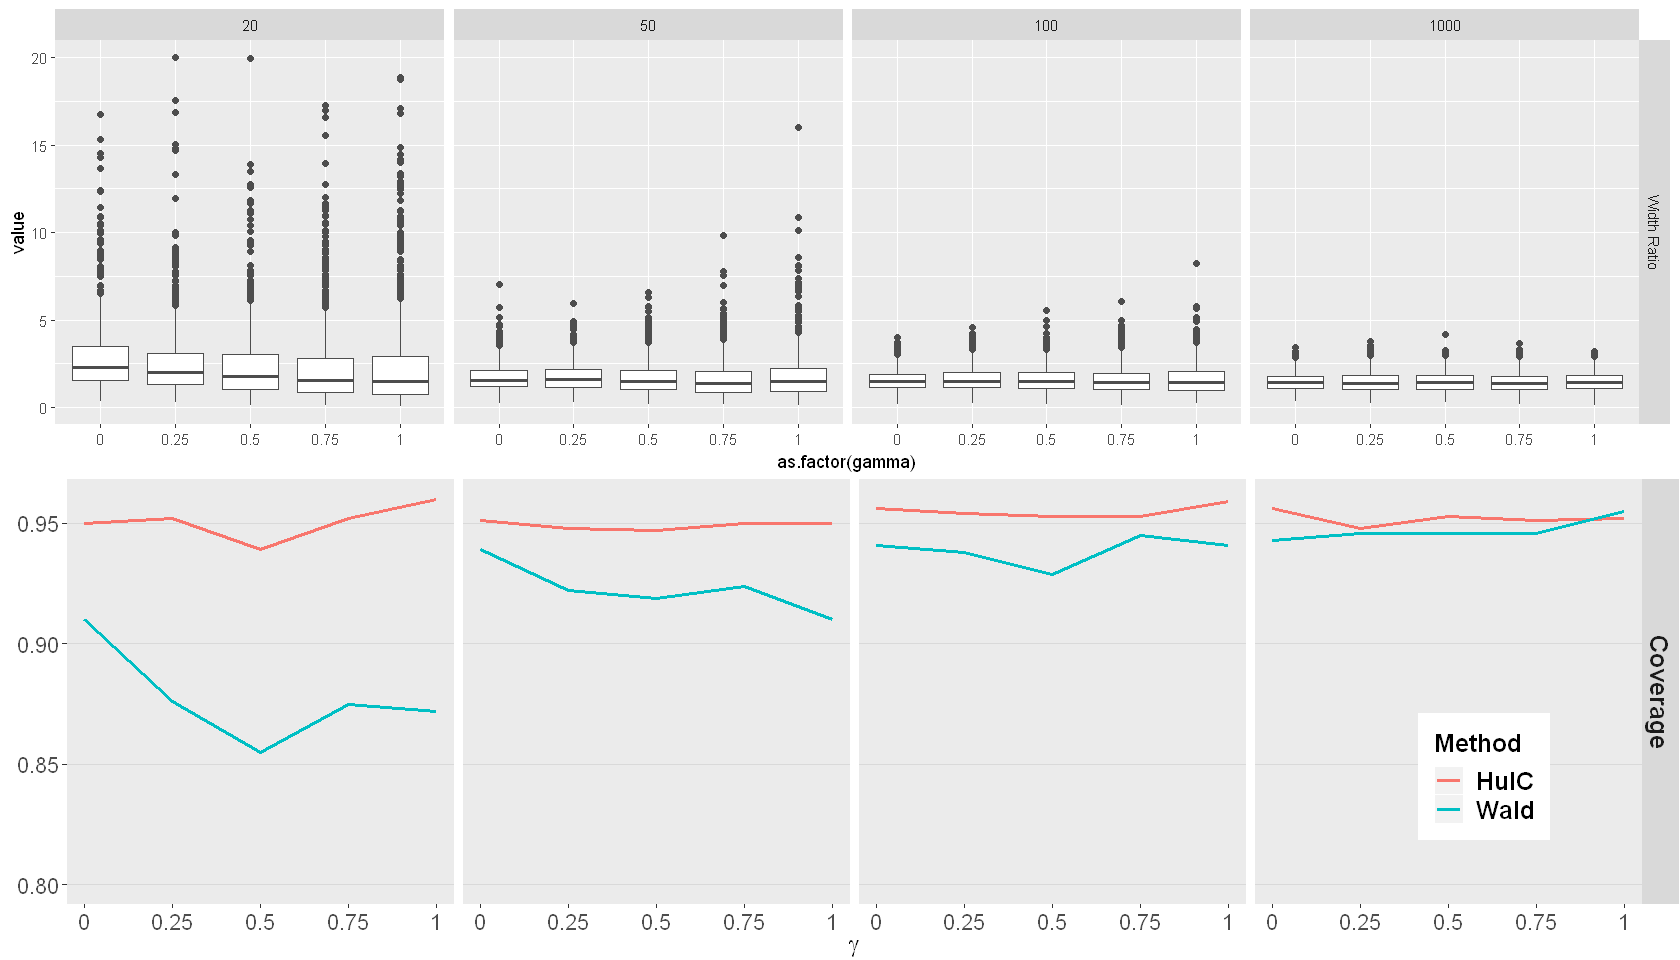

In [6]:
g1 <- ggplot(data = tmp_width_mat, mapping= aes(x=as.factor(gamma), y =value)) +
  geom_boxplot(color="gray30")+ 
  facet_grid(type~as.factor(nsamp)) #+ 
#   geom_hline(yintercept = 1.5, linetype = 1, color = "red")+ 
#   scale_x_discrete(labels = NULL, breaks = NULL) + 
#   labs(x = "",y="")+
#   theme(plot.margin=unit(c(0,0,0,.05), "cm"))+ 
#   coord_cartesian(ylim=c(0, 7.5))+background_grid(major="y", minor="none")
# g1 <- g1 + geom_hline(yintercept=1,color="blue")
# g1 <- g1 + scale_y_continuous(breaks=c(0, 1, 1.5, 2, 4, 6, 7), 
#                     labels=c("0.0", "1.0", "1.5", "2", "4", "6", "7"))
# g1 <- g1 + theme(axis.text.x=element_text(size = 13),
#                 axis.text.y=element_text(size=13,color = c("black", "blue", "red", "black", "black", "black", "black")),
#                 axis.text=element_text(size=12),
#                 axis.title=element_text(size=15,face="bold"),
#                 strip.text = element_text(size=15,face = "bold"),
#                 axis.ticks.y = element_line(color = c("black", "blue", "red", "black", "black", "black", "black"),
#                                     size = c(.5,0.5,0.5,.5,.5,.5,.5)))


levels(col.cov$name)[1] <- "HulC"
g2<-ggplot(data= col.cov, mapping= aes(x=gamma, y =cov, col=name, group= as.factor(name))) +
  ylim(.8, 0.96)+
  geom_line(size = 1.1)+ 
  facet_grid(type~as.factor(nsamp)) + 
#   geom_hline(yintercept = 0.95, linetype = 2) + 
  theme(plot.margin=unit(c(0,0,0,-.2), "cm"),
        legend.position=c(0.9,0.3),
        strip.background.x = element_blank(),
        legend.margin = margin(10, 10, 10, 10),
        axis.text.x=element_text(size = 13),
        axis.text.y=element_text(size=13),
        axis.text=element_text(size=12),
        legend.text=element_text(size=15, face = "bold"),
        legend.title=element_text(size = 15, face = "bold"),
        strip.text.x = element_blank(),    
        axis.title=element_text(size=15,face="bold"),
        strip.text = element_text(size=15,face = "bold") )+ 
  labs(y="", x=expression(gamma))+
  background_grid(major="y", minor="none")+
  scale_color_discrete("Method")+
  scale_x_continuous(breaks=c(0, 0.25, 0.5, 0.75, 1), 
                      labels=c("0", "0.25", "0.5", "0.75", "1"))

options(repr.plot.width=14, repr.plot.height=8)
grid.arrange(g1,g2)